# CEIA Deep Learning - Examen Final - Ej:3

Alumno: Alianak, Juan Pablo

Descargar el dataset desde el siguiente link. El dataset son compras de productos que
diferentes clientes realizaron durante un black sales. El dataset contiene información sobre
las transacciones y el objetivo es poder utilizar el dataset para crear diferentes modelos que
puedan predecir cuánto un cliente está dispuesto a gastar en un producto en el futuro.
Particularmente, vamos a tratar este problema como una clasificación binaria donde
queremos averiguar si el cliente va a gastar mucha plata (más de 9000) o poca plata
(menos de 9000).

a) Entrenar un modelo de deep learning que no utilice embeddings.

b) Entrenar un modelo de deep learning que utilice embeddings tanto para los
productos como los usuarios. Realizar el mapeo de identificador de producto y
usuarios a indices antes de separar el dataset en training, validation y testing.

c) Compare el score de cada modelo y comente lo necesario.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils

from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


### Importamos el dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CEIA/DL/TP_Final/dataset_2.csv')

#### Vemos que contiene el dataset

In [4]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [5]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [6]:
df.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

Observamos que existen 5 variables categoricas y 7 variables numericas

In [7]:
df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

Vemos que las variables Product_Category_2 y Product_Category_3 contienen gran cantidad valores nulos

In [8]:
print(df.nunique())

User_ID                        5891
Product_ID                     3631
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Product_Category_2               17
Product_Category_3               15
Purchase                      18105
dtype: int64


Vemos que sobre las variables User_ID, Producto_ID tienen una alta cantidad de datos unicos, mas adelante vamos a relacionar este hecho con la posibilidad de hacer One-hot encoding

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d0347d390>,
      dtype=object)

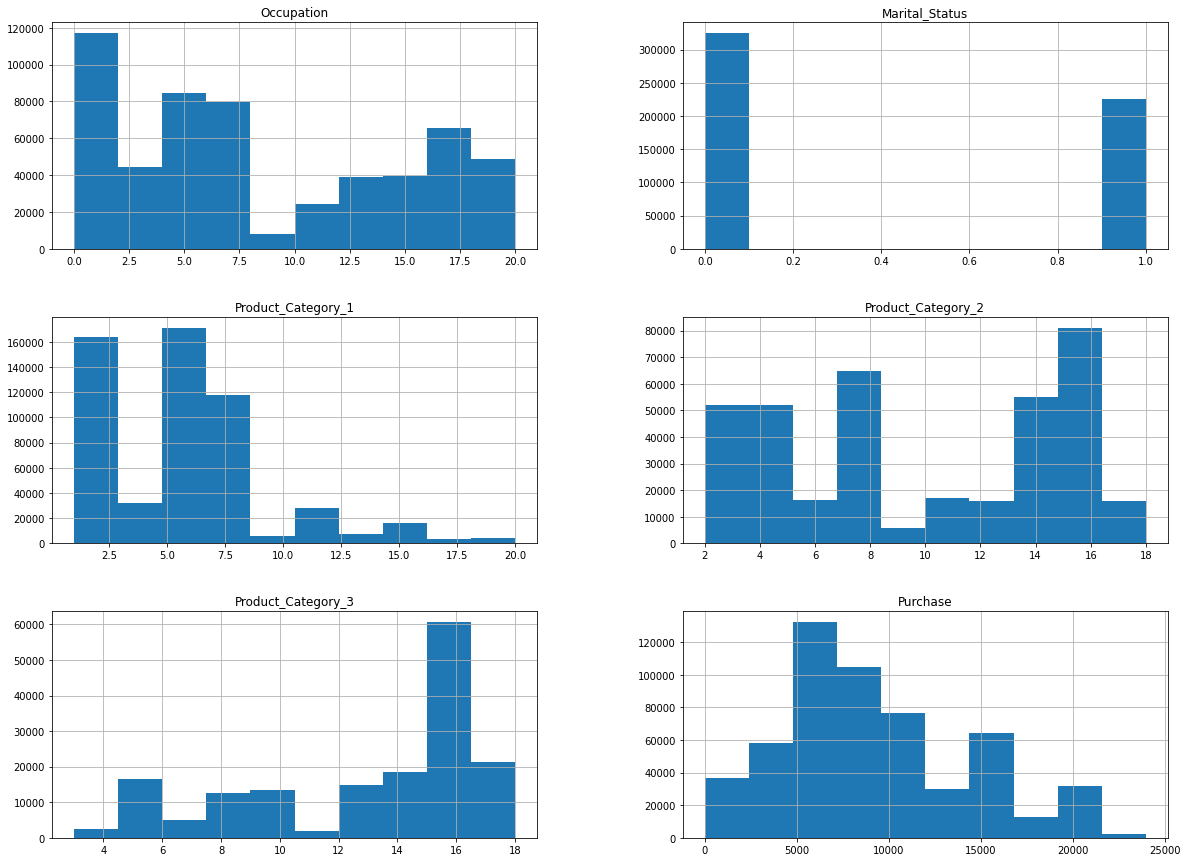

In [9]:
df.hist(['Occupation','Marital_Status','Product_Category_1','Product_Category_2','Product_Category_3','Purchase'],figsize=(20,15))

Algunas de las variables numericas presentan un desbalance, esto lo vamos a tener en cuenta en caso de que la performance del modelo no sea buena

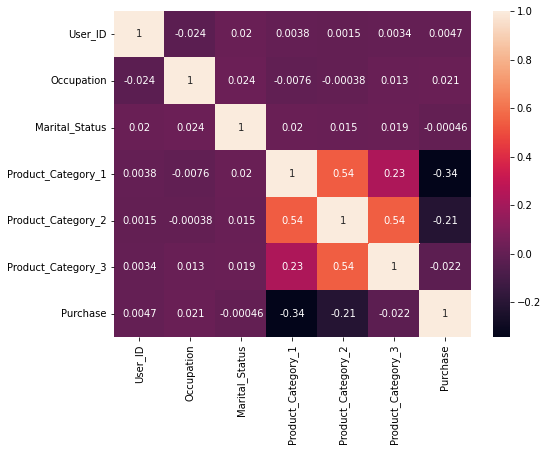

In [10]:
corr_df = df.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

Vemos que las categorias de productos tienen tiene una correlacion entre ellas mayor que el resto de las variables, sobre todo entre Product_Category_1 y Product_Category_2. De ser necesario, podriamos prescindir de una de las 2 variables.

In [4]:
df_new = df.copy()

Dada la gran cantidad de valores nulos que tiene Product_Category_3, decidimos quitarla del analisis. Por el momento vamos a conservar la feature Product_Category_2 dropeando los nulos

In [5]:
df_new = df_new.drop(['Product_Category_3'], axis=1)
df_new = df_new.dropna()

Por la gran cantidad de valores distintos que poseen las variables User_ID y Product_ID, no creemos conveniente hacer un one-hot encoding, ya que agregaria demasiadas feature al modelo, por lo cual guardamos los datos para el posterior embbeding y las eliminamos

In [6]:
User_ID = df_new['User_ID']
Product_ID = df_new['Product_ID']

df_new = df_new.drop(['User_ID'], axis=1) 
df_new = df_new.drop(['Product_ID'], axis=1)

Transformamos la variables Gender, de categorica a numerica y a la variable Purchase la transformamos en binaria, segun si es mayor o menor que 9000

In [7]:
df_new['Gender'] = df_new['Gender'].replace(['F'], [0])
df_new['Gender'] = df_new['Gender'].replace(['M'], [1])
df_new.loc[(df_new.Purchase < 9000), 'Purchase'] = 0
df_new.loc[(df_new.Purchase >= 9000), 'Purchase'] = 1

Al resto de las variables categoricas, le hacemos un one-hot encoding

In [8]:
df_new = pd.get_dummies(df_new)

In [9]:
df_new

,Gender,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Purchase,Age_0-17,Age_18-25,Age_26-35,Age_36-45,...,Age_51-55,Age_55+,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
1,0,10,0,1,6.0,1,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0,10,0,12,14.0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
5,1,15,0,1,2.0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
6,1,7,1,1,8.0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
7,1,7,1,1,15.0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545905,1,6,0,5,8.0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
545906,1,6,0,8,17.0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
545907,1,6,0,2,3.0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
545908,1,6,0,1,2.0,1,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


In [10]:
df_new.dtypes

Gender                             int64
Occupation                         int64
Marital_Status                     int64
Product_Category_1                 int64
Product_Category_2               float64
Purchase                           int64
Age_0-17                           uint8
Age_18-25                          uint8
Age_26-35                          uint8
Age_36-45                          uint8
Age_46-50                          uint8
Age_51-55                          uint8
Age_55+                            uint8
City_Category_A                    uint8
City_Category_B                    uint8
City_Category_C                    uint8
Stay_In_Current_City_Years_0       uint8
Stay_In_Current_City_Years_1       uint8
Stay_In_Current_City_Years_2       uint8
Stay_In_Current_City_Years_3       uint8
Stay_In_Current_City_Years_4+      uint8
dtype: object

Transformamos los datos a numpy, separando la variable label del dataset

In [10]:
y = np.array(df_new['Purchase'])
X = np.array(df_new.drop(['Purchase'], axis=1))

Normalizamos el dataset

In [11]:
X_norm = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

In [12]:
print(X_norm.shape)
print((np.min(X_norm, axis=0)).shape)
print(np.min(X_norm, axis=0))
print(np.max(X_norm, axis=0))

(376430, 20)
(20,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Realizamos la divisionb del dataset en train, valid y test (70-20-10)

In [13]:
n = X_norm.shape[0]
m = X_norm.shape[1]
idx = np.random.permutation(np.arange(0, n))
train_idx = idx[0:int(0.70 * n)]
valid_idx = idx[int(0.70 * n):int(0.90 * n)]
test_idx  = idx[int(0.90 * n):]

In [14]:
y = np.array(y.tolist())

In [15]:
X_train = X_norm[train_idx]
y_train = y[train_idx]
print(X_train.shape)
print(y_train.shape)

X_valid = X_norm[valid_idx]
y_valid = y[valid_idx]
print(X_valid.shape)
print(y_valid.shape)

X_test = X_norm[test_idx]
y_test = y[test_idx]
print(X_test.shape)
print(y_test.shape)

(263501, 20)
(263501,)
(75286, 20)
(75286,)
(37643, 20)
(37643,)


In [16]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
print(device)

cpu


## Definimos las funciones train, test y plot

In [45]:
def train(train,valid,epcoch,emb):

    model.to(device)

    train_loss_by_epoch = []
    train_auc_by_epoch = []

    val_loss_by_epoch = []
    val_auc_by_epoch = []

    for epoch in range(epcoch):

      #########################################################################
      ####### TRAINING
      #########################################################################

      model.train(True)

      train_epoch_loss = 0
      epoch_y_score = []
      epoch_y_label = []

      for i, data in enumerate(train):

          # obtener los datos del batch
          if emb == True:
            X_batch, user_batch, product_batch, y_batch = data
            user_batch = user_batch.to(device).long()
            product_batch = product_batch.to(device).long()
          else:
            X_batch, y_batch = data

          X_batch = X_batch.to(device).float()
          y_batch = y_batch.to(device).float()
        
          # forward
          optimizer.zero_grad()
        
          if emb == True:
            train_output = model(X_batch, user_batch, product_batch)
          else:
            train_output = model(X_batch)
          
          y_batch_hat = train_output
          y_batch = y_batch.reshape(-1, 1)
        
          # compute loss
          loss = loss_function(y_batch_hat, y_batch)

          # backpropagation
          loss.backward()

          # actualizar los parameteros
          optimizer.step()

          # acumular el loss
          train_epoch_loss = train_epoch_loss + loss.item()
          epoch_y_score += list(y_batch_hat.detach().cpu().numpy())
          epoch_y_label += list(y_batch.detach().cpu().numpy()) 
 
      # epoch_loss -> tengo acumulado el error de todo el dataset en un epoch
      train_loss_by_epoch.append(train_epoch_loss / len(train_dataset))

      # compute AUC
      fpr, tpr, _ = metrics.roc_curve(epoch_y_label, epoch_y_score)
      train_auc = metrics.auc(fpr, tpr)
      train_auc_by_epoch.append(train_auc)
    
      #########################################################################
      ####### VALIDATING
      #########################################################################

      model.train(False)

      val_epoch_loss = 0
      val_epoch_y_score = []
      val_epoch_y_label = []

      for i, data in enumerate(valid):

          # obtener los datos del batch
          if emb == True:
            X_batch, user_batch, product_batch, y_batch = data
            user_batch = user_batch.to(device).long()
            product_batch = product_batch.to(device).long()
          else:
            X_batch, y_batch = data

          X_batch = X_batch.to(device).float()
          y_batch = y_batch.to(device).float()

          # forward
          optimizer.zero_grad()
        
          if emb == True:
            val_output = model(X_batch, user_batch, product_batch)
          else:
            val_output = model(X_batch)

          y_batch_hat = val_output
          y_batch = y_batch.reshape(-1, 1)

          # compute loss
          loss = loss_function(y_batch_hat, y_batch)

          # acumular el loss
          val_epoch_loss = val_epoch_loss + loss.item()
          val_epoch_y_score += list(y_batch_hat.detach().cpu().numpy())
          val_epoch_y_label += list(y_batch.detach().cpu().numpy()) 

      # epoch_loss -> tengo acumulado el error de todo el dataset en un epoch
      val_loss_by_epoch.append(val_epoch_loss / len(valid_dataset))
    
      # compute AUC
      fpr, tpr, _ = metrics.roc_curve(val_epoch_y_label, val_epoch_y_score)
      val_auc = metrics.auc(fpr, tpr)
      val_auc_by_epoch.append(val_auc)

      #########################################################################
      ####### EPOCH PRINTS
      #########################################################################

      print(f"Epoch: {epoch} | Training loss: {train_epoch_loss / len(y_train)} | Training AUC: {train_auc} | Valid loss: {val_epoch_loss / len(y_train)} | Valid AUC: {val_auc}")

    plot(train_loss_by_epoch,val_loss_by_epoch,train_auc_by_epoch,val_auc_by_epoch)

In [44]:
def test(test,emb):
    
  model.train(False)
  
  # obtener los datos del batch
  data = next(iter(test))

  if emb == True:
    X_batch, user_batch, product_batch, y_batch = data
    user_batch = user_batch.to(device).long()
    product_batch = product_batch.to(device).long()
  else:
    X_batch, y_batch = data

  X_batch = X_batch.to(device).float()
  y_batch = y_batch.to(device).float()

  # forward
  if emb == True:
    test_output = model(X_batch, user_batch, product_batch)
  else:
    test_output = model(X_batch)

  y_test_hat = test_output
  y_batch = y_batch.reshape(-1, 1)

  # compute loss
  test_loss = loss_function(test_output, y_batch)

  # epoch_loss -> tengo acumulado el error de todo el dataset en un epoch
  test_loss = (test_loss / len(y_batch))

  test_y_score = y_test_hat.detach().cpu().numpy()
  test_y_label = y_batch.detach().cpu().numpy()

  # compute AUC
  fpr, tpr, _ = metrics.roc_curve(test_y_label, test_y_score)
  test_auc = metrics.auc(fpr, tpr)

  print(f"Test loss: {test_loss / len(y_batch)} | Test AUC: {test_auc}")

In [29]:
def plot(train_loss,val_loss,train_auc,val_auc):
  
  fix, ax = plt.subplots(1,2,figsize=(20,7))

  ax[0].plot(train_loss, label='Train')
  ax[0].plot(val_loss, label='Valid')
  ax[0].set_title("Loss vs. epoch")
  ax[0].legend()


  ax[1].plot(train_auc, label='Train')
  ax[1].plot(val_auc, label='Valid')
  ax[1].set_title("AUC vs. epoch")
  ax[1].legend()


  plt.show()

## Cargamos los datos para que puedan ser consumidos por los modelos

In [17]:
class Data(Dataset):
    def __init__(self,x, y):
  
        self.x=torch.Tensor(x)
        self.y=torch.Tensor(y)
        self.y=self.y.view(-1,1)
        self.len=self.x.shape[0]

    def __getitem__(self,index):    
        return self.x[index], self.y[index]
        
    def __len__(self):
        return self.len

In [18]:
train_dataset  = Data(X_train, y_train)
valid_dataset  = Data(X_valid, y_valid)
test_dataset   = Data(X_test, y_test)

train_loader  = DataLoader(dataset=train_dataset, batch_size=32)
valid_loader  = DataLoader(dataset=valid_dataset, batch_size=32)
test_loader   = DataLoader(dataset=test_dataset, batch_size=len(y_test))

## Modelo sin Embedding

In [19]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(in_features=20, out_features=100, bias=True)
        self.relu_1 = nn.ReLU()
        self.linear_2 = nn.Linear(in_features=100, out_features=50, bias=True)
        self.relu_2 = nn.ReLU()
        self.output = nn.Linear(in_features=50, out_features=1, bias=True)

    def forward(self, x):       
        x = self.linear_1(x)    
        x = self.relu_1(x)      
        x = self.linear_2(x)    
        x = self.relu_2(x)      
        x = torch.sigmoid(self.output(x))      
        return x   

Epoch: 0 | Training loss: 0.014463108001909631 | Training AUC: 0.8564083327182488 | Valid loss: 0.003459703492045452 | Valid AUC: 0.890783352401148
Epoch: 1 | Training loss: 0.011947718360431589 | Training AUC: 0.8912596377834512 | Valid loss: 0.0033853802045326004 | Valid AUC: 0.8950128029785976
Epoch: 2 | Training loss: 0.011636974456972132 | Training AUC: 0.8965337414927252 | Valid loss: 0.003246317798674013 | Valid AUC: 0.901873377789037
Epoch: 3 | Training loss: 0.011024872923163263 | Training AUC: 0.9031767702349177 | Valid loss: 0.0030931325428959116 | Valid AUC: 0.90649233004396
Epoch: 4 | Training loss: 0.010751784440968939 | Training AUC: 0.9070912244978915 | Valid loss: 0.0030525472878119983 | Valid AUC: 0.9100726434496395
Epoch: 5 | Training loss: 0.010695923866916871 | Training AUC: 0.9084978059020004 | Valid loss: 0.00304205464653252 | Valid AUC: 0.9105449456330263
Epoch: 6 | Training loss: 0.010655153807852492 | Training AUC: 0.9094174805878021 | Valid loss: 0.0030450808

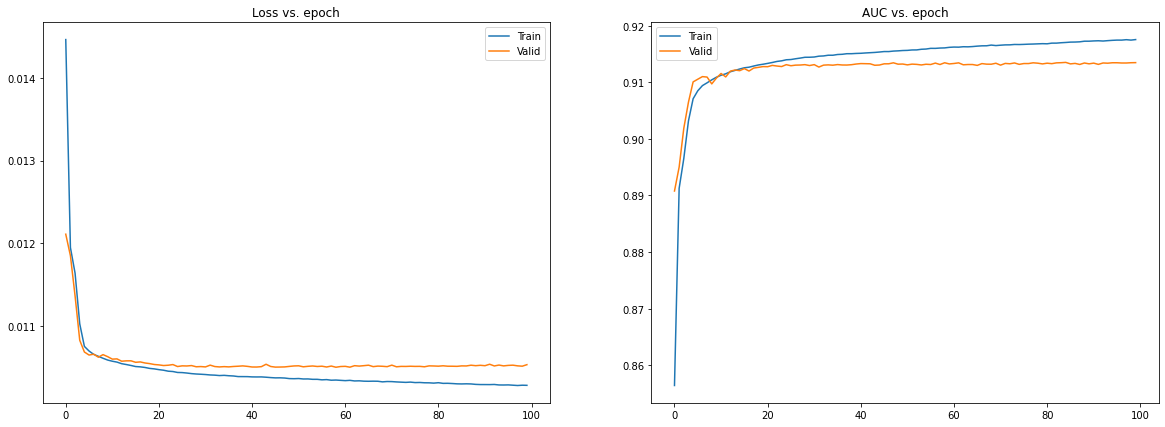

Test loss: 2.361670303763219e-10 | Test AUC: 0.9139307830131358


In [31]:
model = Net()
loss_function=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

train(train_loader,valid_loader,100,False)
test(test_loader,False)

Si bien la performace es buena, se nota overfitting en los resultados (hay un estancamiento de la performance en valid, mientras que en train sigue mejorando).

## EMBEDDING

In [32]:
# map user id a user index 
unique = np.unique(User_ID)
index = np.arange(0, len(unique)) # [0,1,...,499]
user_id_to_index = {key:value for key, value in zip(unique, index)}
user_idx = np.array([user_id_to_index[v] for v in User_ID])
num_user = len(unique)
print(type(num_user))
print(num_user)

<class 'int'>
5891


In [33]:
# map user id a user index 
unique = np.unique(Product_ID)
index = np.arange(0, len(unique)) # [0,1,...,499]
product_id_to_index = {key:value for key, value in zip(unique, index)}
product_idx = np.array([product_id_to_index[v] for v in Product_ID])
num_product = len(unique)
print(type(num_product))
print(num_product)

<class 'int'>
1803


In [34]:
class DataEmb(Dataset):
    def __init__(self,x, user_idx, product_idx, y):
  
        self.x=torch.Tensor(x)
        self.y=torch.Tensor(y)
        self.y=self.y.view(-1,1)
        self.user_idx = torch.Tensor(user_idx)
        self.product_idx = torch.Tensor(product_idx)
        self.len=self.x.shape[0]

    def __getitem__(self,index):    
        return self.x[index],self.user_idx[index],self.product_idx[index], self.y[index]
        
    def __len__(self):
        return self.len

In [35]:
user_index_train = user_idx[train_idx]
user_index_valid = user_idx[valid_idx]
user_index_test = user_idx[test_idx]
product_index_train = product_idx[train_idx]
product_index_valid = product_idx[valid_idx]
product_index_test = product_idx[test_idx]
train_dataset_emb = DataEmb(X_train, user_index_train, product_index_train, y_train)
valid_dataset_emb = DataEmb(X_valid, user_index_valid, product_index_valid, y_valid)
test_dataset_emb = DataEmb(X_test, user_index_test, product_index_test, y_test)

In [40]:
train_loader_emb  = DataLoader(dataset=train_dataset_emb, batch_size=32)
valid_loader_emb  = DataLoader(dataset=valid_dataset_emb, batch_size=32)
test_loader_emb  = DataLoader(dataset=test_dataset_emb, batch_size=len(y_test))

## Modelo con Embedding

In [37]:
class NNetWithEmb(nn.Module):

    def __init__(self, num_user, num_product, d):
        super().__init__()
        self.embedding1 = torch.nn.Embedding(num_embeddings=num_user, embedding_dim=d)
        self.embedding2 = torch.nn.Embedding(num_embeddings=num_product, embedding_dim=d)
        self.linear_1 = nn.Linear(in_features=28, out_features=100, bias=True)
        self.relu_1 = nn.ReLU()
        self.linear_2 = nn.Linear(in_features=100, out_features=50, bias=True)
        self.relu_2 = nn.ReLU()
        self.output = nn.Linear(in_features=50, out_features=1, bias=True)

    def forward(self, x, us_idx, prod_idx):
        user_emb = self.embedding1(us_idx)
        product_emb = self.embedding2(prod_idx)
        final_input = torch.cat([x, user_emb, product_emb], dim=1)
        x = self.linear_1(final_input)    
        x = self.relu_1(x)     
        x = self.linear_2(x)   
        x = self.relu_2(x)     
        x = torch.sigmoid(self.output(x))     
        return x

Epoch: 0 | Training loss: 0.012406638717689234 | Training AUC: 0.8970799870740875 | Valid loss: 0.002864132554290074 | Valid AUC: 0.9309137778118541
Epoch: 1 | Training loss: 0.009439711685151954 | Training AUC: 0.9379851064769529 | Valid loss: 0.002683597396787886 | Valid AUC: 0.9385786045826134
Epoch: 2 | Training loss: 0.008956041097429266 | Training AUC: 0.9442781205829285 | Valid loss: 0.0026224505599112863 | Valid AUC: 0.941483524600349
Epoch: 3 | Training loss: 0.00867238348647223 | Training AUC: 0.948166996294353 | Valid loss: 0.0025884163193374277 | Valid AUC: 0.9432966562436295
Epoch: 4 | Training loss: 0.008470864590131594 | Training AUC: 0.9508700140033528 | Valid loss: 0.0025687138218684867 | Valid AUC: 0.9444149698840192
Epoch: 5 | Training loss: 0.008318733306238044 | Training AUC: 0.952833730730671 | Valid loss: 0.0025574286245089693 | Valid AUC: 0.9450416320317246
Epoch: 6 | Training loss: 0.00819882082270142 | Training AUC: 0.9543372106945394 | Valid loss: 0.002553524

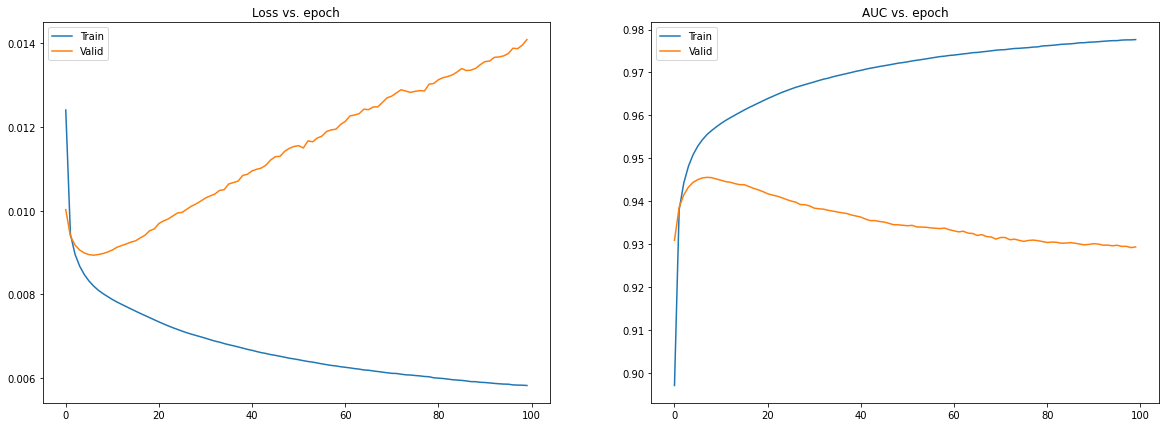

Test loss: 3.1265456890139376e-10 | Test AUC: 0.9309535249799603


In [46]:
model = NNetWithEmb(num_user, num_product,4)
loss_function=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

train(train_loader_emb, valid_loader_emb, 100, True)
test(test_loader_emb, True)

Se aprecia un notable overfitting, para lo cual vamos a agregarle regularizacion al modelo.

Epoch: 0 | Training loss: 0.013811167726832467 | Training AUC: 0.8740284482299561 | Valid loss: 0.003035863289438535 | Valid AUC: 0.9289835023975566
Epoch: 1 | Training loss: 0.010588574387249135 | Training AUC: 0.9298637111251602 | Valid loss: 0.0030027622794310195 | Valid AUC: 0.9306628922683293
Epoch: 2 | Training loss: 0.010503619803762927 | Training AUC: 0.9310427756317128 | Valid loss: 0.0029950780239523826 | Valid AUC: 0.931052105097373
Epoch: 3 | Training loss: 0.010484947914080578 | Training AUC: 0.9312900278567747 | Valid loss: 0.0029924522634887166 | Valid AUC: 0.9312264143413498
Epoch: 4 | Training loss: 0.010469516278085489 | Training AUC: 0.9315072182978739 | Valid loss: 0.0029898159178118884 | Valid AUC: 0.9313804083838514
Epoch: 5 | Training loss: 0.010459580770927575 | Training AUC: 0.9316559579233447 | Valid loss: 0.0029891802651893546 | Valid AUC: 0.9314295773160796
Epoch: 6 | Training loss: 0.01045814882445114 | Training AUC: 0.9316761068076271 | Valid loss: 0.00298

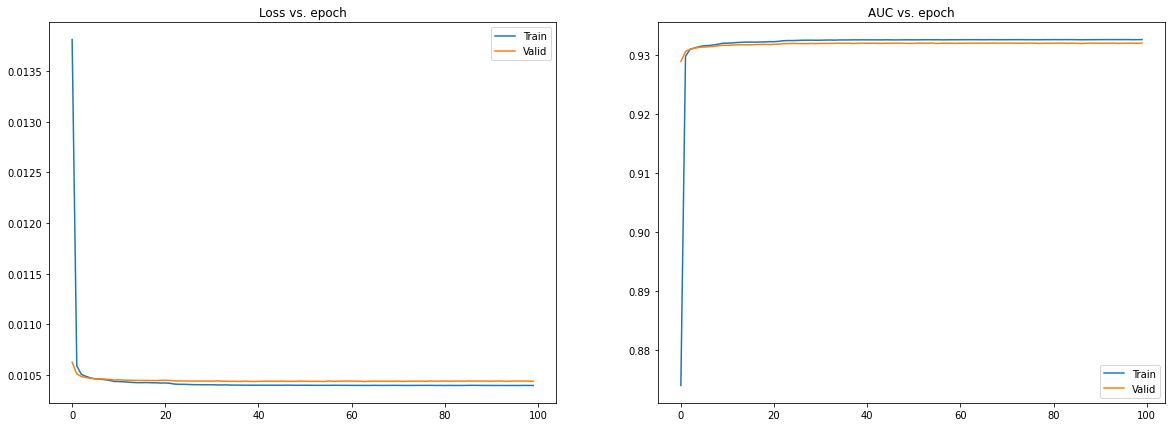

Test loss: 2.334488158339809e-10 | Test AUC: 0.9338943100154444


In [47]:
model = NNetWithEmb(num_user, num_product,4)
loss_function=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

train(train_loader_emb, valid_loader_emb, 100, True)
test(test_loader_emb, True)

Conclusion: El modelo con embedding y regularizacion logra un buen equilibrio entre performance y un fit correcto. Si bien el modelo con embedding sin regularizacion logra una mejor performance mayor en train, hace demasiado overfitting, quedandonos con el modelo con regularizacion como el mejor de los ensayados